# Do Transverse Bunch Tails Produce Luminosity?

## Relevant functions


In [1]:
import numpy as np
from scipy.special import gamma
from matplotlib import pyplot as plt
from scipy.special import hyp2f1

def q_log(x, q):
    """Compute the q-logarithm."""
    if q == 1:
        return np.log(x)
    else:
        return (x**(1 - q) - 1) / (1 - q)


def q_exponential(x, q):
    """Computes the q-exponential function."""
    if q==1:
        return np.exp(x)
    else:
        valid_base = 1 + (1 - q) * x
        valid_base[valid_base < 0] = 0
        return valid_base ** (1 / (1 - q))

def C_q(q):
    """Computes the normalization factor C_q."""
    if  q < 1:
        return (2 * np.sqrt(np.pi) * gamma(1 / (1 - q))) / ((3 - q) * np.sqrt(1 - q) * gamma((3 - q) / (2 * (1 - q))))
    elif q == 1:
        return np.sqrt(np.pi)
    elif 1 < q < 3:
        return (np.sqrt(np.pi) * gamma((3 - q) / (2 * (q - 1)))) / (np.sqrt(q - 1) * gamma(1 / (q - 1)))
    else:
        raise ValueError("q must be in the range (0, 3).")

def q_gaussian(x, q, beta):
    """Computes the q-Gaussian probability density function."""
    if beta<= 0:
        raise ValueError('beta should be positive')
    if q>3:
        raise ValueError('q should be <3.')
    if 1<=q<3:
        return (np.sqrt(beta) / C_q(q)) * q_exponential(-beta * x**2, q)
    if q<1:
        my_limit = 1/np.sqrt(beta*(1-q))
        return np.where(
        (-my_limit <= x) & (x <= my_limit), 
        (np.sqrt(beta) / C_q(q)) * q_exponential(-beta * x**2, q),
        0
    )

def Q_x(x, q, beta):
    return beta*(q-1)*x**2+1

def Q_x_x0(x, x0, q, beta):
    return beta*(3*q-5)*x**2+beta*(6-4*q)*x0**2-1

def A_plus(x, x0, q, beta):
    return hyp2f1(1, (q-2)/(q-1), 1/2, (Q_x(x, q, beta)-Q_x(x0, q, beta))/Q_x(x, q, beta))

def A_minus(x, x0, q, beta):
    return hyp2f1(1, (q-2)/(q-1), -1/2, (Q_x(x, q, beta)-Q_x(x0, q, beta))/Q_x(x, q, beta))

def rho_x_x0(x, x0, q, beta):
    num = Q_x(x0, q, beta)**(1/(1-q)+1/2)*(Q_x_x0(x, x0, q, beta)* A_plus(x, x0, q, beta)+Q_x(x0, q, beta)*A_minus(x, x0, q, beta))
    dem = np.pi*np.sqrt(x0**2-x**2)*Q_x(x, q, beta)
    result = -num/dem
    return np.nan_to_num(result, nan=0.0)
    

## Box-Muller generalization

The generalized Box–Muller technique can generates pairs of q-Gaussian deviates that are **not** independent. The following formula will generate deviates from a q-Gaussian with specified parameter q $\beta$.

$X = \sqrt{-\frac{2}{(3-q)\beta} \text{ ln}_{{1+q} \over {3-q}}(U_1)} \text{ cos}(2 \pi U_2) $,

$Y = \sqrt{-\frac{2}{(3-q)\beta} \text{ ln}_{{1+q} \over {3-q}}(U_1)} \text{ sin}(2 \pi U_2) $.


<!-- where $\text{ ln}_q$ is the q-logarithm and $q' = { {1+q} \over {3-q}}$

These deviates can be transformed to generate deviates from an arbitrary q-Gaussian by
$ Z' = \mu + {Z \over \sqrt{\beta (3-q)}}$ wuth $Z \in \{X, Y\}$ -->


In [2]:
def generalized_box_muller(q, beta, size=1):
    """Generate q-Gaussian deviates using the generalized Box-Muller transform."""
    if beta<= 0:
        raise ValueError('beta should be positive')
    q_prime = (1 + q) / (3 - q)  # Compute q'
    
    # Generate uniform random numbers
    U1 = np.random.uniform(0, 1, size)
    U2 = np.random.uniform(0, 1, size)
    # Compute the transformation
    factor = np.sqrt(-2 / (beta*(3-q)) * q_log(U1, q_prime))
    X = factor * np.cos(2 * np.pi * U2)
    Y = factor * np.sin(2 * np.pi * U2)
    
    return X, Y

(-10.0, 10.0)

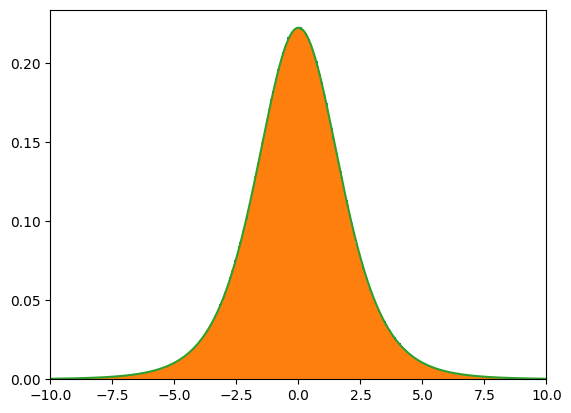

In [3]:
q = 1.3
beta = 0.2

X, Y = generalized_box_muller(q, beta, size=10000000)

plt.hist(X, 1000,density=True);
plt.hist(Y, 1000,density=True);

my_range = np.linspace(-10,10,1000)
plt.plot(my_range, q_gaussian(my_range, q, beta))

plt.xlim(-10,10)

# Test 1
\begin{equation}
    \frac{de_q^{-\beta x}}{dx} = 
    %(e_q^x)^q= 
    - \beta e_{2-\frac{1}{q}}^{-q\beta x}
    \label{eq:e_q}
\end{equation}

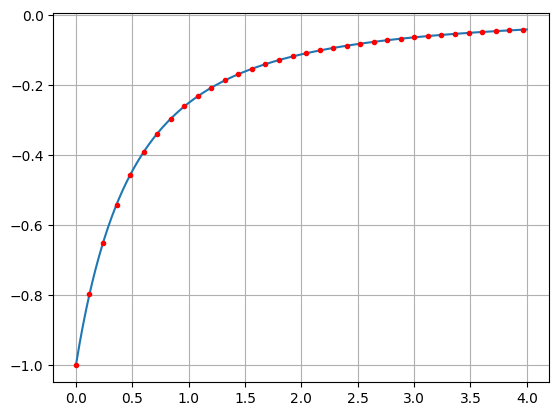

In [4]:
beta=1
q =2
x_range = np.linspace(0,4,1000) 
y = q_exponential(-beta*x_range,q)
#plt.plot(x_range, y)
plt.plot(x_range, np.gradient(y,  x_range) )

yy= -beta*q_exponential(-beta*q*x_range,2-1/q)
plt.plot(x_range[::30], yy[0::30],'r.')
plt.grid()

# Test 2
\begin{equation}
    \int e_q^{-\beta x} dx=-\frac{1}{\beta (2-q)} e_{\frac{1}{2-q}}^{-\beta (2-q) x} 
    +\text{const,}
    \label{eq:int_exp}
\end{equation}

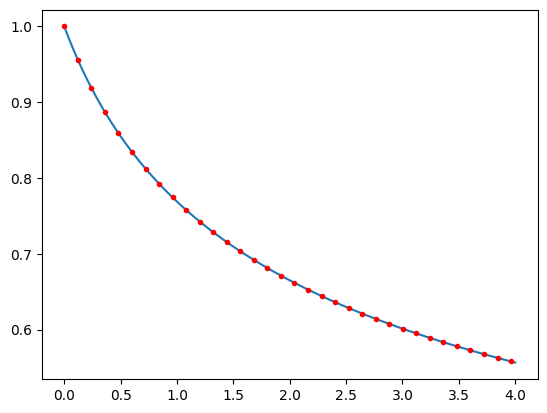

In [5]:
beta=0.4
q =4
x_range = np.linspace(0,4,1000) 
y = -1/(beta*(2-q))*q_exponential(-beta*(2-q)*x_range,1/(2-q))
# plt.plot(x_range, y)
plt.plot(x_range, np.gradient(y,  x_range) )

yy= q_exponential(-beta*x_range,q)
plt.plot(x_range[0::30], yy[0::30],'r.')

# Test 3
\begin{equation}
\begin{split}
    \int x e_q^{-\beta x} dx=&-\frac{x}{\beta (2-q)} e_{\frac{1}{2-q}}^{-\beta (2-q) x} \\
    &-\frac{1}{\beta^2(2-q)(3-2q)}
    e_{\frac{2-q}{3-2q}}^{-\beta(3-2q)x}\\
    &+\text{const.}
\end{split}
\label{eq:integral_xexpq}
\end{equation}

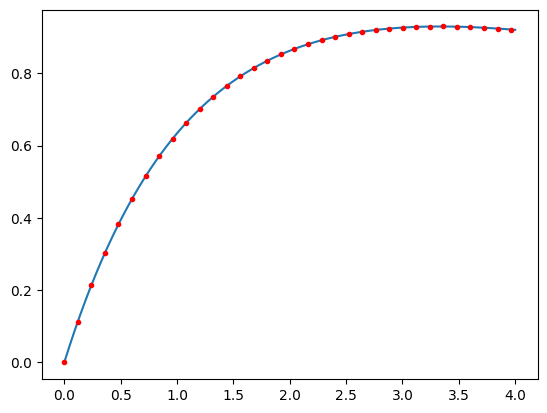

In [6]:
beta=0.5
q =1.4
x_range = np.linspace(0,4,1000) 
y = -x_range/(beta*(2-q))*q_exponential(-beta*(2-q)*x_range,1/(2-q))-1/(beta**2*(2-q)*(3-2*q))*q_exponential(-beta*(3-2*q)*x_range,(2-q)/(3-2*q))

plt.plot(x_range, np.gradient(y,  x_range) )
yy= x_range*q_exponential(-beta*x_range,q)
plt.plot(x_range[0::30], yy[0::30],'r.')

# Test 4
\begin{equation}
\mathcal{A}^{-1} (q_{gaussian}(x, q, \beta)) = \frac{ (3-q)\beta}{2\pi }\ e_{\frac{3q-1}{1+q}}^{-\frac{(1+q)\beta}{2}  \rho^2}.
\end{equation}


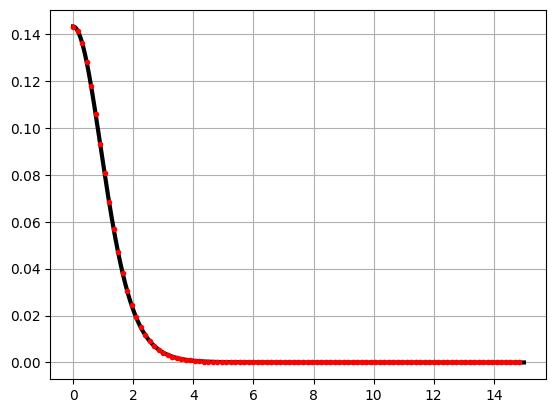

In [7]:
# from https://bblumi.web.cern.ch/how-tos/abel_transform/Abel_Transform/
from scipy.stats import chi
import numpy as np
from matplotlib import pyplot as plt

#def gauss(x,sigma):
#    return 1/np.sqrt(2*np.pi)/sigma*np.exp(-(x)**2/2/sigma**2)

r=np.linspace(0.00001,15,20000)
# rho_r=chi.pdf(r,2)
# plt.plot(r, rho_r,'r',lw=3,label='$\\rho_r$')

q = 1.2
beta = .5

#find rho
#rho=rho_r/2/np.pi/r
rho = q_gaussian(r, q, beta)
#rho[np.where(r>r_cut)]=0
from abel.direct import direct_transform
from abel.tools.analytical import GaussianAnalytical
aux=direct_transform(rho, dr=np.diff(r)[0], direction="inverse", correction=True)

#plt.plot(r,rho,'b',lw=3,label='$\\rho$')

#plt.plot(r,rho,'k',label='Abel Transform of $\\rho$', lw=3)

plt.plot(r,aux,'k',label='Abel Transform of $\\rho$', lw=3)


plt.plot(r[::200],(3-q)*beta/2/np.pi* q_exponential(-beta*(1+q)*r**2/2, (3*q-1)/(q+1))[::200],'.r')
#plt.plot(r[::200], beta/np.pi* q_exponential(-beta*q*r**2, 2-1/q)[::200],'.r')

# plt.plot(r[0::5],gauss(r[0::5],1),'or',label='Normal distribution', lw=3)

# plt.plot(r, q_gaussian(r, q, beta))

# plt.ylabel('pdf (symmetric for x<0)')
# plt.xlabel('x [$\\sigma$]')
# plt.legend(loc='best')
plt.grid(True)

# Test 5


\begin{equation}
\mathcal{A}[e_q^{-\beta\ r^2}]=\frac{\pi\sqrt{3-q}}{(2-q)\sqrt{2 \beta}C_\frac{q+1}{3-q}} e_{\frac{q+1}{3-q}}^{-\frac{3-q}{2}\beta x^2}
\end{equation}

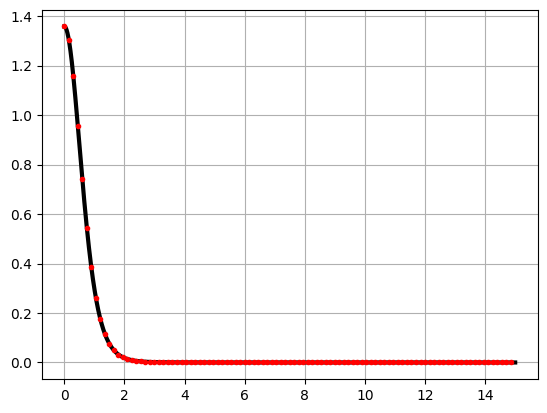

In [8]:
from scipy.stats import chi
import numpy as np
from matplotlib import pyplot as plt

#def gauss(x,sigma):
#    return 1/np.sqrt(2*np.pi)/sigma*np.exp(-(x)**2/2/sigma**2)

r=np.linspace(0.00001,15,20000)
# rho_r=chi.pdf(r,2)
# plt.plot(r, rho_r,'r',lw=3,label='$\\rho_r$')

q = 1.2
beta = 2

#find rho
#rho=rho_r/2/np.pi/r
rho = q_exponential(-beta*r**2, q)
from abel.direct import direct_transform
from abel.tools.analytical import GaussianAnalytical
aux=direct_transform(rho, dr=np.diff(r)[0], direction="direct", correction=True)

#plt.plot(r,rho,'b',lw=3,label='$\\rho$')

plt.plot(r,aux,'k',label='Abel Transform of $\\rho$', lw=3)


plt.plot(r[::200],np.pi*np.sqrt((3-q))/(2-q)/np.sqrt(2*beta)/C_q((q+1)/(3-q))* q_exponential(-beta*(3-q)*r**2/2, (q+1)/(3-q))[::200],'.r')

plt.grid(True)

# Test 6

\begin{equation}
\mathcal{A}^{-2}(e_q^{-\beta\ \xi^2})=\frac{\beta}{\pi} e_{2-\frac{1}{q}}^{-q \beta\ \xi^2}
\end{equation}

\begin{equation}
\mathcal{A}^{-1}(e_q^{-\beta\ \xi^2})=\frac{(3-q)\sqrt{\beta} C_q}{2\pi} e_{\frac{3q-1}{q+1}}^{-\frac{(1+q)\beta}{2}\ \xi^2}
\end{equation}

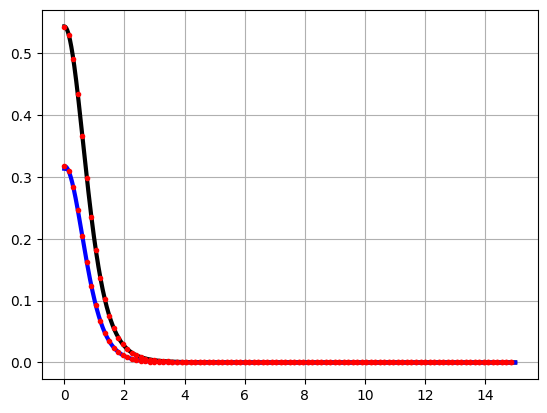

In [9]:
# from https://bblumi.web.cern.ch/how-tos/abel_transform/Abel_Transform/
from scipy.stats import chi
import numpy as np
from matplotlib import pyplot as plt

#def gauss(x,sigma):
#    return 1/np.sqrt(2*np.pi)/sigma*np.exp(-(x)**2/2/sigma**2)

r=np.linspace(0.00001,15,20000)
# rho_r=chi.pdf(r,2)
# plt.plot(r, rho_r,'r',lw=3,label='$\\rho_r$')

q = 1.3
beta = 1
r_cut = 3

#find rho
#rho=rho_r/2/np.pi/r
rho = q_exponential(-beta*r**2, q)#*np.sqrt(beta)/C_q(q)
#rho[np.where(r>r_cut)]=0
from abel.direct import direct_transform
from abel.tools.analytical import GaussianAnalytical
aux=direct_transform(rho, dr=np.diff(r)[0], direction="inverse", correction=True)
aux2=direct_transform(aux, dr=np.diff(r)[0], direction="inverse", correction=True)

#plt.plot(r,rho,'b',lw=3,label='$\\rho$')

plt.plot(r,aux,'k',label='Abel Transform of $\\rho$', lw=3)

plt.plot(r,aux2,'b',label='Abel Transform of $\\rho$', lw=3)

plt.plot(r[::200],(3-q)*np.sqrt(beta)/2/np.pi*C_q(q)* q_exponential(-beta*(1+q)*r**2/2, (3*q-1)/(q+1))[::200],'.r')
plt.plot(r[::200], beta/np.pi* q_exponential(-beta*q*r**2, 2-1/q)[::200],'.r')

# plt.plot(r[0::5],gauss(r[0::5],1),'or',label='Normal distribution', lw=3)

# plt.plot(r, q_gaussian(r, q, beta))

# plt.ylabel('pdf (symmetric for x<0)')
# plt.xlabel('x [$\\sigma$]')
# plt.legend(loc='best')
plt.grid(True)

In [10]:
# Test the non-factorization
q = 1
x = np.random.rand(1)
y = np.random.rand(1)
assert np.isclose(q_exponential(x+y,q)-q_exponential(x,q)*q_exponential(y,q), 0)

(-10.0, 10.0)

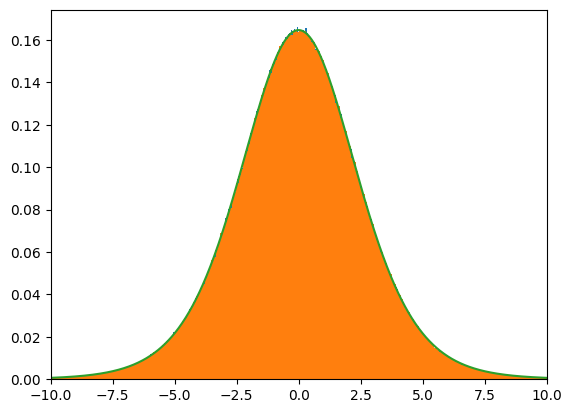

In [11]:
q = 1.2
beta = .1

X, Y = generalized_box_muller(q, beta, size=3000000)

plt.hist(X, 1000,density=True);
plt.hist(Y, 1000,density=True);

my_range = np.linspace(-10,10,1000)
plt.plot(my_range, q_gaussian(my_range, q, beta))

plt.xlim(-10,10)

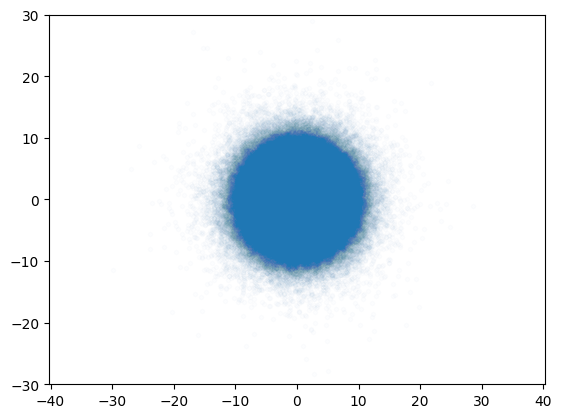

In [12]:
plt.plot(X, Y,'.',alpha=.01)
plt.axis('equal')
plt.xlim(-30,30)
plt.ylim(-30,30);

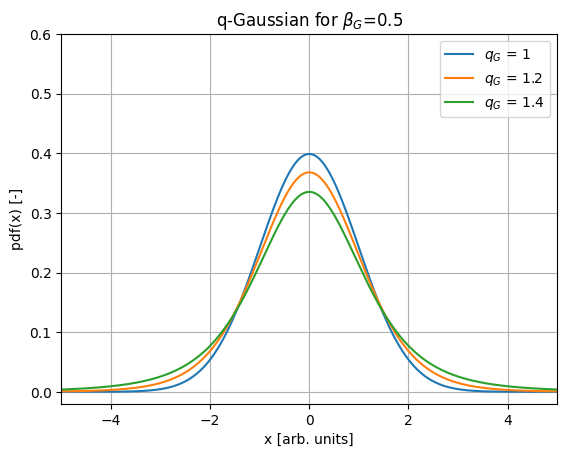

In [13]:
# Comparison of q-Gaussian at constant beta
my_range = np.linspace(-10,10,1000)

my_beta = 0.5
for my_q in [1,1.2,1.4]:
    plt.plot(my_range, q_gaussian(my_range, my_q, my_beta), label=f'$q_G$ = {my_q}')

plt.xlim(-5,5)
plt.ylim(-0.02,0.6)

plt.xlabel('x [arb. units]')
plt.ylabel('pdf(x) [-]')
plt.title(f'q-Gaussian for $\\beta_G$={my_beta}')
plt.grid()
plt.legend()
    


(-0.02, 0.6)

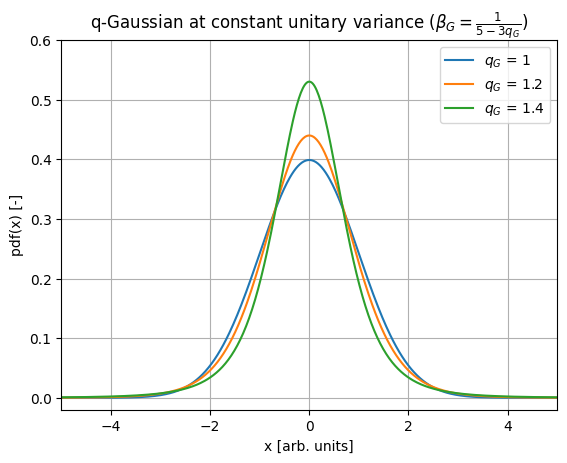

In [14]:
# Comparison of q-Gaussian at constant std deviation
my_range = np.linspace(-10,10,1000)

for my_q in [1,1.2,1.4]:
    plt.plot(my_range, q_gaussian(my_range, my_q, 1/(5-3*my_q)), label=f'$q_G$ = {my_q}')

plt.xlim(-5,5)
plt.xlabel('x [arb. units]')
plt.ylabel('pdf(x) [-]')
plt.title('q-Gaussian at constant unitary variance ($\\beta_G=\\frac{1}{5-3 q_G}$)')
plt.grid()
plt.legend()
plt.ylim(-0.02,0.6)

(-10.0, 10.0)

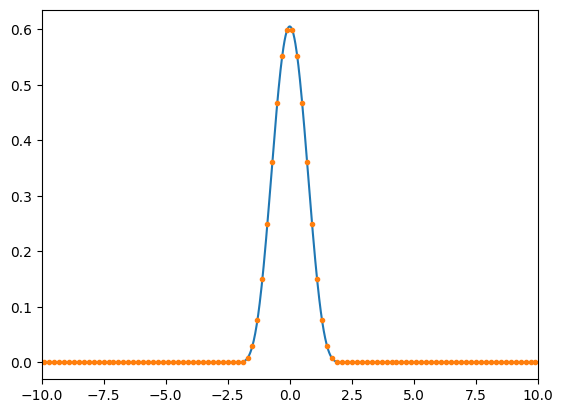

In [15]:
# beta as scaling factor
my_range = np.linspace(-10,10,1000)
plt.plot(my_range, q_gaussian(my_range, .8, 1))
plt.plot(my_range*np.sqrt(100), 1/np.sqrt(100)*q_gaussian(my_range, .8, 100),'.')
plt.xlim(-10,10)

More in general we have from https://arxiv.org/pdf/1205.1690 (Eq. 9)

$\rho_{X}(x) = {\sqrt{\beta} \over C_q}\ e_q^{-\beta x^2}$

$
\rho_{X,Y}(x,y) = \frac{ (3-q)\beta}{2\pi }\ e_{\frac{3q-1}{1+q}}^{-\frac{(1+q)\beta}{2}  (x^2 + y^2)}
$
this is equivalent to the Eq.20 of https://accelconf.web.cern.ch/ipac2024/pdf/MOPC09.pdf (with $r = \sqrt{x^2 + y^2}$), that is the  inverse Abel tranform of the q-Gaussian.

It is to be noted that the previous equation cannot be factorized in x,y. 

Applying a new Abel transform we have 

$
\rho_{X,Y,P_X}(x,y, p_x) = \frac{(3-q)\beta^2 C_{\frac{3 q-1}{1+q}}}{\pi^2 \sqrt{2(1+q)\beta}}  \ e_{2-\frac{1}{q}}^{- q \beta  (x^2 + y^2 + p_x^2)}
$



Applying a new Abel transform we have 

$
\rho_{X,Y,P_X,P_Y}(x,y,p_x,p_y) = \frac{(3-q)(1+q) \beta^2 C_{2-\frac{1}{q}} C_{\frac{3 q-1}{1+q}} }{2 \pi^3 \sqrt{2 q(1+q)}} \ e_{\frac{2-3 q}{1-2q}}^{-(2q-1) \beta\  (x^2 + y^2 + p_x^2 + p_y^2)}
$



For a Gaussian q=1 and beta=0.5 so we get

$
\rho_{X,Y,P_X,P_Y}(x,y,p_x,p_y) = \frac{1}{4\pi^2} \ e^{- \frac{x^2 + y^2 + p_x^2 + p_y^2}{2}}
$


In [16]:
# This is the check
import numpy as np

def f_2D(r_x, q, beta_q):
    numerator = - (beta_q ** (3/2)) * (q - 3) * np.sqrt(q - 1) * r_x
    denominator = 2 * np.pi
    
    factor1 = (1 / (beta_q * (q - 1) * r_x**2) + 1) ** ((q + 1) / (2 - 2 * q))
    factor2 = (beta_q * (q - 1) * r_x**2) ** (q / (1 - q))
    
    return (numerator / denominator) * factor1 * factor2


r=.1
q_g=1.2
beta_g=1

((3-q_g)*beta_g)/2/np.pi*q_exponential(-(1+q_g)*beta_g/2*np.array([r])**2, (3*q_g-1)/(1+q_g))-f_2D(r, q_g, beta_g)


array([1.60982339e-15])

In [17]:
# This is the check
import numpy as np

from scipy.special import gamma
def f_4D(r_x, q, beta_q):
    numerator = - beta_q * (q - 3) * (q + 1) * (1/(beta_q*(q-1)))**(1/(1-q))
    denominator = 4 * np.pi**2* gamma(1/(q-1))*r_x**3
    
    factor1 =  (beta_q*(q-1))**((q+1)/(2-2*q))*gamma(q/(q-1))
    factor2 = (1/(beta_q*r_x**2*(q-1))+1)**(1/(1-q)-3/2)
    factor3 = (beta_q*r_x**2*(q-1))**(1/(1-q))
    
    return (numerator / denominator) * factor1 * factor2 * factor3


r=2
q_g=1.4
beta_g=1

((3-q_g)*(1+q_g)*beta_g**2)/4/np.pi**2*q_exponential(-(3*q_g-1)*beta_g/2*np.array([r])**2, (5*q_g-3)/(3*q_g-1))-f_4D(r, q_g, beta_g)


array([3.03576608e-18])



How is it distributed $r = \sqrt{x^2 + y^2}$?

$
\rho_R(r) = (3-q)\beta\ r \exp_{\frac{3q-1}{1+q}} \left( -\frac{(1+q)\beta}{2}  r^2 \right)
$

$X = \sqrt{-\frac{2}{(3-q)\beta} \text{ ln}_{{1+q} \over {3-q}}(U_1)} \text{ cos}(2 \pi U_2) $,

https://en.wikipedia.org/wiki/N-sphere#Spherical_coordinates


(0.0, 20.0)

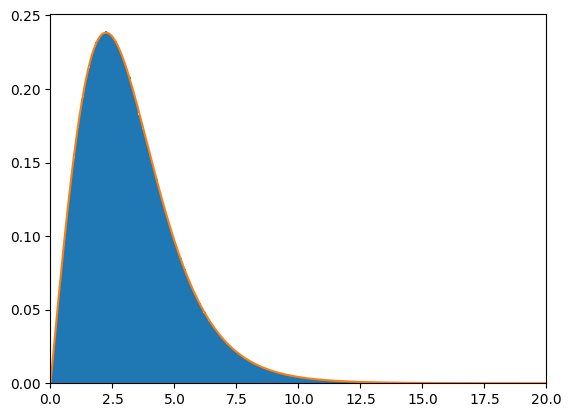

In [18]:
plt.hist(np.sqrt(X**2+Y**2),1000, density=True);
my_range = np.linspace(0,20,1000)
plt.plot(my_range, ((3-q)*beta)*my_range*q_exponential(-(1+q)*beta/2*my_range**2, (3*q-1)/(1+q)))
plt.xlim(0.,20)

How is it distributed $J = (x^2 + y^2)/2$?

$
\rho_J(J) =  (3-q)\beta\ \exp_{\frac{3q-1}{1+q}} \left( -(1+q)\beta\  J \right)
$


$X = \sqrt{-\frac{2}{(3-q)\beta} \text{ ln}_{{1+q} \over {3-q}}(U_1)} \text{ cos}(2 \pi U_2) $,


(0.0, 20.0)

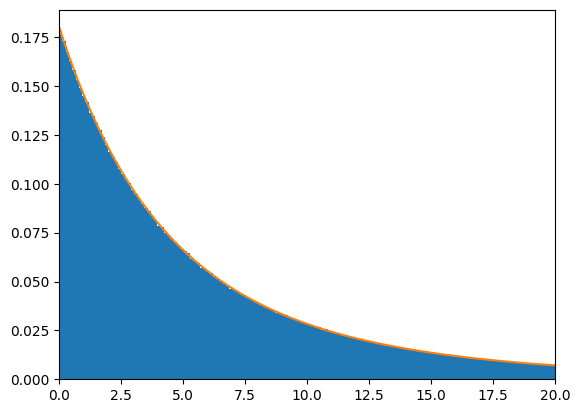

In [19]:
plt.hist((X**2+Y**2)/2,10000, density=True);
my_range = np.linspace(0,20,1000)
plt.plot(my_range, ((3-q)*beta)*q_exponential(-(1+q)*beta*my_range, (3*q-1)/(1+q)))
plt.xlim(0.,20)


This is the inverse Abel transform of the q-Gaussian (q,$\beta$) after replacing $r^2= x^2 + y^2$, that is it is equivalent to Eq. 20 of https://accelconf.web.cern.ch/ipac2024/pdf/MOPC09.pdf.


$\rho_J(J) =  (3-q)\beta\ \exp_{\frac{3q-1}{1+q}} \left( -(1+q)\beta\  J \right)$

This means that the $J = (x^2 + y^2)/2=R^2/2$ is distributed as a q-exponential:

$(2-q') \lambda e_{q'}(-\lambda x)$

where $\lambda=(1+q) \beta$ and $q'=\frac{3q-1}{1+q} $


The mean J is then $\frac{1}{\lambda(3-2 q')}= \frac{1}{\beta (5-3 q)}$ for $q<\frac{5}{3}$

The corresponding CDF is $1-e_{\frac{1}{2-q'}}^{-\lambda (2-q')J} =1 - e_{\frac{1+q}{3-q}}^{-(3-q)\beta J}$

np.float64(-1.0395286093478617e-05)

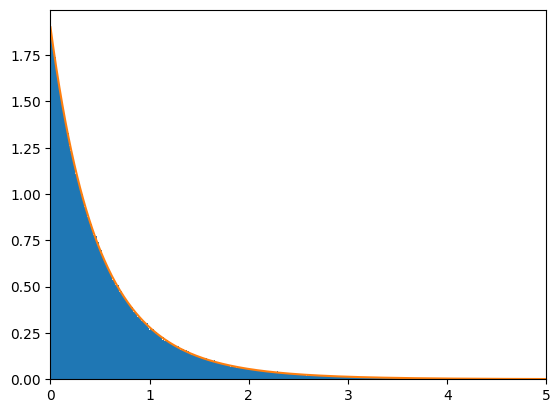

In [20]:
# For a Gaussian
my_size = 5000000
q = 1.1
beta = 1 
X, Y = generalized_box_muller(q, beta, size=my_size)
J =(X**2+ Y**2)/2
plt.hist(J,10000, density=True);
my_range = np.linspace(0,10,1000)
plt.plot(my_range, ((3-q)*beta)*q_exponential(-(1+q)*beta*my_range, (3*q-1)/(1+q)))
plt.xlim(0.,5)

np.mean(J)-1/(beta*(5-3*q))

This allows us to compute the residual bunch current if we cut at $J=\frac{r^2}{2}$.

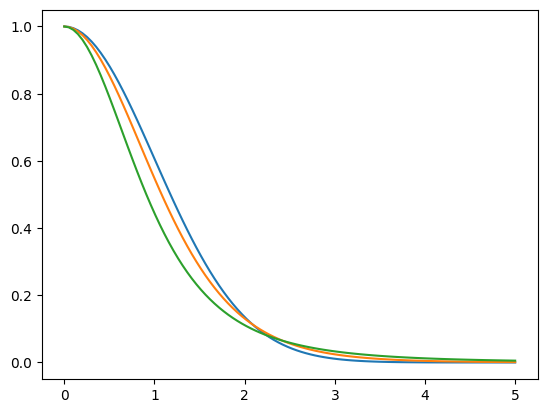

In [21]:
def cdf_q_exp(r, q, beta):
    my_lambda = (1+q)*beta
    qprime = (3*q-1)/(1+q)
    #return 1-q_exponential(-my_lambda*(2-qprime)*r**2/2, 1/(2-qprime))
    return 1-q_exponential(-(3-q)*beta*r**2/2, (1+q)/(3-q))

my_q = 1.4
my_r = np.linspace(0,5,100)
plt.plot(my_r,1-cdf_q_exp(my_r, 1, 1/(5-3*1)))
plt.plot(my_r,1-cdf_q_exp(my_r, 1.2, 1/(5-3*1.2)))
plt.plot(my_r,1-cdf_q_exp(my_r, 1.4, 1/(5-3*1.4)))

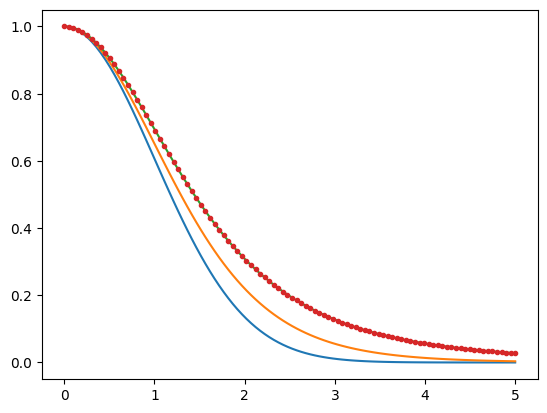

In [22]:
plt.plot(my_r,1-cdf_q_exp(my_r, 1, 0.5))
plt.plot(my_r,1-cdf_q_exp(my_r, 1.2, 0.5))
plt.plot(my_r,1-cdf_q_exp(my_r, 1.4, 0.5))
my_size = 5000000
X, Y = generalized_box_muller(1.4, 0.5, size=my_size)
r = np.sqrt(X**2+ Y**2)
my_value = []
for my_radius in np.linspace(0,5, 100):
    my_value.append(len(np.where(r>my_radius)[0])/my_size)

plt.plot(np.linspace(0,5, 100), my_value, '.')

# Abel transform
$
\rho_J(J) =  (3-q)\beta\ \exp_{\frac{3q-1}{1+q}} \left( -(1+q)\beta\  J \right)
$

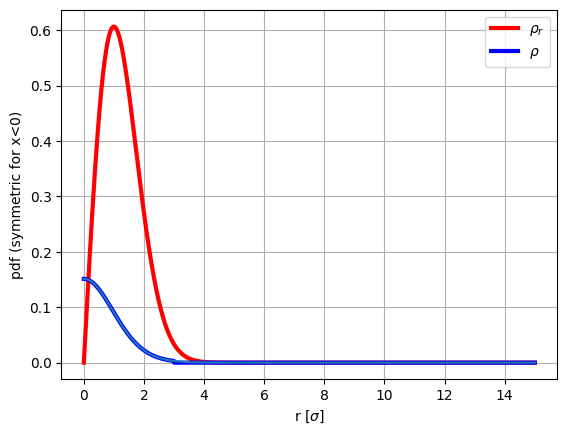

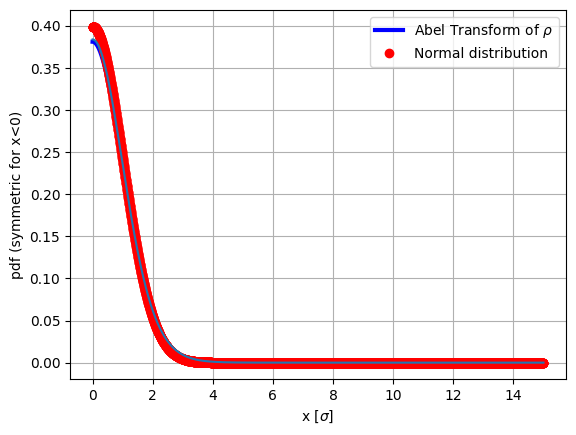

In [23]:
# from https://bblumi.web.cern.ch/how-tos/abel_transform/Abel_Transform/
from scipy.stats import chi
import numpy as np
from matplotlib import pyplot as plt

def gauss(x,sigma):
    return 1/np.sqrt(2*np.pi)/sigma*np.exp(-(x)**2/2/sigma**2)

r=np.linspace(0.00001,15,20000)
rho_r=chi.pdf(r,2)
plt.plot(r, rho_r,'r',lw=3,label='$\\rho_r$')

q = 1.1
beta = .5
r_cut = 3

#find rho
rho=rho_r/2/np.pi/r
rho = ((3-q)*beta)*q_exponential(-(1+q)*beta*r**2/2, (3*q-1)/(1+q))/2/np.pi
rho[np.where(r>r_cut)]=0
from abel.direct import direct_transform
from abel.tools.analytical import GaussianAnalytical
aux=direct_transform(rho, dr=np.diff(r)[0], direction="forward", correction=True)

plt.plot(r,rho,'b',lw=3,label='$\\rho$')

plt.plot(r, ((3-q)*beta)*q_exponential(-(1+q)*beta*r**2/2, (3*q-1)/(1+q))/2/np.pi)

plt.grid(True)
plt.ylabel('pdf (symmetric for x<0)')
plt.xlabel('r [$\\sigma$]')
plt.legend(loc='best')


plt.figure()
plt.plot(r,aux,'b',label='Abel Transform of $\\rho$', lw=3)

plt.plot(r[0::5],gauss(r[0::5],1),'or',label='Normal distribution', lw=3)

plt.plot(r, q_gaussian(r, q, beta))

plt.ylabel('pdf (symmetric for x<0)')
plt.xlabel('x [$\\sigma$]')
plt.legend(loc='best')
plt.grid(True)

## $\beta$ vs $q$

We will consider case:
- constant  $\beta$
- constant  variance, that is $\beta = \frac{1}{5-3q}$
- constant $\mathcal{L}$

0.9999999999999998
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0
1.000000000000002
0.9999999999994115
1.0000000000000002
0.9999999999999998
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000004
1.0000000000000009
1.0000000000000022
1.0000000000000036
1.0000000000000078
1.0000000000000164
1.0000000000000304
1.0000000000000528
1.0000000000000888
1.0000000000001428
1.0000000000002218
1.000000000000334
1.0000000000004894
0.9999999999994205
0.9999999999997123
1.0
1.0000000000000004
0.9999999999999998
1.0
0.9999999999999998
0.9999999999999996
0.9999999999999998
1.0000000000000007
0.9999999999999998
0.9999999999999994
0.9999999999999998
1.0
0.9999999999999998
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0
1.0000000000000004
1.0
1.0
0.9999999999999998
0.9999999999999998
1.0
0.9999999999999998
1.0000000000000007
0.9999999999999998
1.0
0.9999999999999998
0.9999999999999998
1.0000000000000007
1.0
1.0000000000000002
0.9999999999999994
1.0
1.00

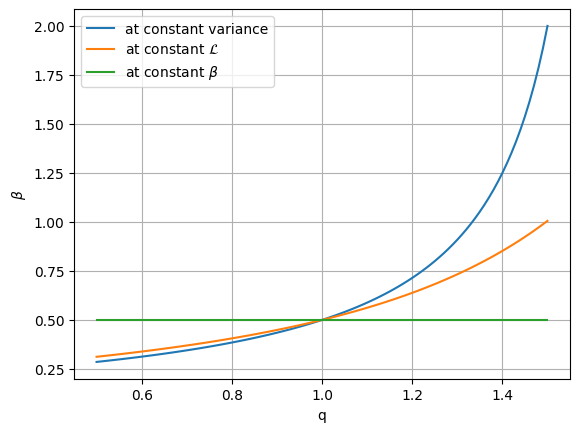

In [24]:
# at constant variance
q2=np.linspace(0.5, 1.5, 101)
beta2 = 1/(5-3*q2)
plt.plot(q2, beta2,'-', label = 'at constant variance')


r=np.linspace(0,15,30000)
Lref = 2*np.trapezoid(q_gaussian(r, 1, 0.5)**2, r)


from scipy.optimize import root_scalar



#Find the root (must specify an interval [a, b] where f(a) and f(b) have opposite signs)
q3=np.linspace(0.5, 1.5, 101)
beta3 = []

for q in q3:
    # Define the function
    if q!=1:
        def f(x):
            return 2*np.trapezoid(q_gaussian(r, q, x)**2, r)/Lref - 1
        root = root_scalar(f, bracket=[.01, 5])  # Search between 0 and 5
        beta3.append(root['root'])
    else:
        beta3.append(0.5)
    print( 2*np.trapezoid(q_gaussian(r, q, beta3[-1])**2, r)/Lref)

plt.plot(q3, beta3,'-', label = 'at constant $\\mathcal{L}$')

# at constant beta
q1=np.linspace(0.5, 1.5, 101)
beta1 = q1*0+0.5
plt.plot(q1, beta1,'-' , label = 'at constant $\\beta$')


plt.grid()
plt.xlabel('q')
plt.ylabel('$\\beta$')
plt.legend()


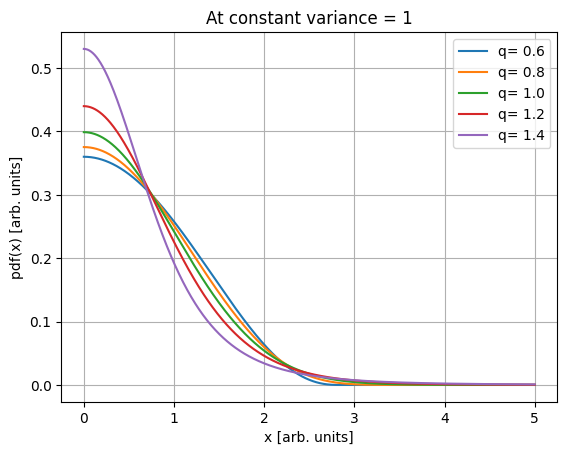

In [25]:
# at constant variance
r=np.linspace(0,5,1000)
for my_q, my_beta in zip(q2[10::20], beta2[10::20]):
    plt.plot(r, q_gaussian(r, my_q, my_beta),label = f'q= {my_q:1.2}')
plt.legend()
plt.grid()
plt.xlabel('x [arb. units]')
plt.ylabel('pdf(x) [arb. units]')
plt.title('At constant variance = 1');

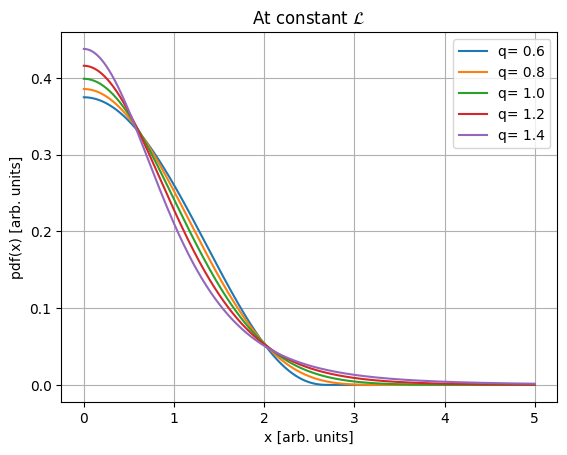

In [26]:
# at constant L
r=np.linspace(0,5,1000)
for my_q, my_beta in zip(q3[10::20], beta3[10::20]):
    plt.plot(r, q_gaussian(r, my_q, my_beta),label = f'q= {my_q:1.3}')
plt.legend()
plt.grid()
plt.xlabel('x [arb. units]')
plt.ylabel('pdf(x) [arb. units]')
plt.title('At constant $\\mathcal{L}$');

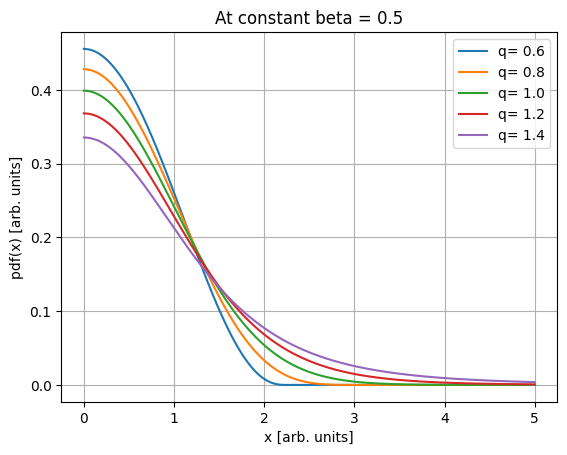

In [27]:
# at constant beta
r=np.linspace(0,5,1000)
for my_q, my_beta in zip(q1[10::20], beta1[10::20]):
    plt.plot(r, q_gaussian(r, my_q, my_beta),label = f'q= {my_q:1.2}')
plt.legend()
plt.grid()
plt.xlabel('x [arb. units]')
plt.ylabel('pdf(x) [arb. units]')
plt.title('At constant beta = 0.5');

In [28]:
rho

array([0.1511972 , 0.15119715, 0.15119701, ..., 0.        , 0.        ,
       0.        ])

ZeroDivisionError: float division by zero

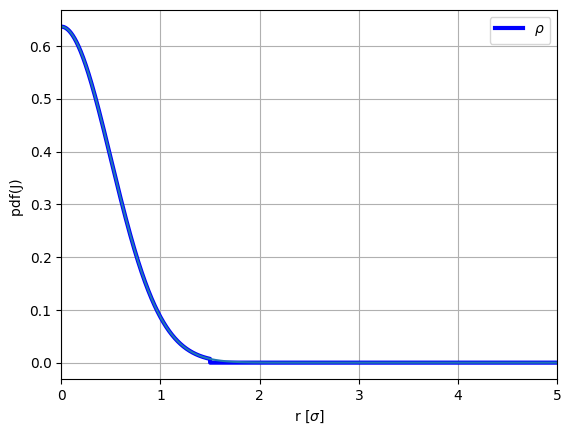

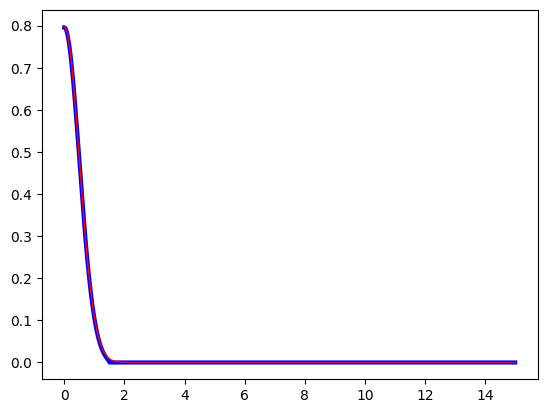

In [29]:
# from https://bblumi.web.cern.ch/how-tos/abel_transform/Abel_Transform/
from scipy.stats import chi
import numpy as np
from matplotlib import pyplot as plt

# def gauss(x,sigma):
#     return 1/np.sqrt(2*np.pi)/sigma*np.exp(-(x)**2/2/sigma**2)

r=np.linspace(0,15,20000)
# rho_r=chi.pdf(r,2)
# plt.plot(r, rho_r,'r',lw=3,label='$\\rho_r$')

q =1. #q3[1]
beta = 2 #beta3[1]
r_cut = 1.5

#find rho
#rho=rho_r/2/np.pi/r
rho = ((3-q)*beta)*q_exponential(-(1+q)*beta*r**2/2, (3*q-1)/(1+q))/2/np.pi
rho[np.isnan(rho)]=0
rho[np.where(r>r_cut)]=0
from abel.direct import direct_transform
from abel.tools.analytical import GaussianAnalytical
aux=direct_transform(rho, dr=np.diff(r)[0], direction="forward", correction=True)

plt.plot(r,rho,'b',lw=3,label='$\\rho$')

plt.plot(r, ((3-q)*beta)*q_exponential(-(1+q)*beta*r**2/2, (3*q-1)/(1+q))/2/np.pi)

plt.grid(True)
plt.ylabel('pdf(J) ')
plt.xlabel('r [$\\sigma$]')
plt.legend(loc='best')
plt.xlim([0,5])

plt.figure()
plt.plot(r,aux,'b',label='Abel Transform of $\\rho$', lw=3)
plt.plot(r,q_gaussian(r,q, beta),'r',label='Unperturbed profile', lw=1)
from scipy.special import erf

def custom_function(x, r_cut):
    coefficient = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
    erf_part = erf(np.sqrt((r_cut**2 - x**2) / 2))
    return coefficient * erf_part    

from scipy.special import hyp2f1


# def custom_function2(x, q, beta, r_cut):
#     if q==1:
#         return custom_function(x, r_cut)
#     else:
#         x0 = r_cut
#         a = (1+(-1+q)*x0**2*beta)**(1/2+1/(1-q))
#         b = (1+(-1+q)*x0**2*beta)
#         c = hyp2f1(1, (-2+q)/(-1+q), -1/2, (-1+q)*(x-x0)*(x+x0)*beta/(1+(-1+q)*x**2*beta))
#         d = -1+(-5+3*q)*x**2*beta+(6-4*q)*x0**2*beta
#         e = hyp2f1(1, (-2+q)/(-1+q), 1/2, (-1+q)*(x-x0)*(x+x0)*beta/(1+(-1+q)*x**2*beta))
#         f = np.pi*np.sqrt(x0**2-x**2)*(1+(q-1)*x**2*beta)     
#         aux = -a*(b*c+d*e)/f
#         aux = np.nan_to_num(aux, nan=0.0)
#         return aux

# plt.plot(r,custom_function(r,r_cut),'g',label='Analytical computation', lw=1)

#plt.plot(r, custom_function2(r,q, beta, r_cut) ,'y',label='Analytical computation', lw=1)

plt.plot(r, rho_x_x0(r,r_cut, q, beta ) ,'y',label='Analytical computation', lw=1)


# plt.plot(r[0::5],gauss(r[0::5],1),'or',label='Normal distribution', lw=3)

# plt.plot(r, q_gaussian(r, q, beta))

plt.ylabel('pdf (symmetric for x<0)')
plt.xlabel('x [$\\sigma$]')
plt.legend(loc='best')
plt.xlim([0,5])
plt.grid(True)


Lref = 2*np.trapezoid(q_gaussian(r, 1, 0.5)**2, r)
L= 2*np.trapezoid(aux**2, r)/Lref
print(L)

In [ ]:
from abel.direct import direct_transform
from abel.tools.analytical import GaussianAnalytical

r=np.linspace(0,30,25000)

q = 1
beta = 0.5

rho = ((3-q)*beta)*q_exponential(-(1+q)*beta*r**2/2, (3*q-1)/(1+q))/2/np.pi
aux=direct_transform(rho, dr=np.diff(r)[0], direction="forward", correction=True)
Lref = 2*np.trapezoid(aux**2, r)

dict_of_L = {}
dict_of_I = {}
dict_of_I0 = {}
dict_of_E = {}
dict_of_E0 = {}


for r_cut in [1,2,3,4,5,6]:
    L = []
    I = []
    E = []
    E0 = []
    I0 = []
    for my_q, my_beta in zip(q3[::5], beta3[::5]):
        print(f'q={my_q}')
        q = my_q
        beta = my_beta
    
        rho = ((3-q)*beta)*q_exponential(-(1+q)*beta*r**2/2, (3*q-1)/(1+q))/2/np.pi
        J = r**2/2
        rhoJ = ((3-q)*beta)*q_exponential(-(1+q)*beta*J, (3*q-1)/(1+q))

        rho[np.isnan(rho)] = 0
        rhoJ[np.isnan(rhoJ)] = 0
        E0.append(np.trapezoid(rhoJ*J, J))
        I0.append(np.trapezoid(rho*r*2*np.pi, r))
    
        rho[np.where(r>r_cut)] = 0
        rhoJ[np.where(J>r_cut**2/2)] = 0

        I.append(np.trapezoid(rho*r*2*np.pi, r))
        E.append(np.trapezoid(rhoJ*J, J))
        aux=direct_transform(rho, dr=np.diff(r)[0], direction="forward", correction=True)
    
        L.append(2*np.trapezoid(aux**2, r)/Lref)
    dict_of_L[f'r_cut={r_cut}']  = np.array(L)
    dict_of_I[f'r_cut={r_cut}']  = np.array(I)
    dict_of_E[f'r_cut={r_cut}']  = np.array(E)
    dict_of_E0[f'r_cut={r_cut}']  = np.array(E0)
    dict_of_I0[f'r_cut={r_cut}']  = np.array(I0)

In [ ]:
# scraping effect on emittance
for r_cut in [3, 4, 5, 6]:
    plt.plot(q3[::5], dict_of_E0[f'r_cut={r_cut}'])
plt.grid(True)

In [ ]:
# scraping effect on emittance
for r_cut, my_color in zip([3, 4, 5, 6], ['b','r','g','k']):
    plt.plot(q3[::5], (dict_of_E[f'r_cut={r_cut}']-dict_of_E0[f'r_cut={r_cut}'])/dict_of_E0[f'r_cut={r_cut}'], f's{my_color}')
plt.grid(True)



def deltaI_I0 (q, beta, x_cut):
    return -q_exponential(-(3-q)*beta*x_cut**2/2, (1+q)/(3-q))

def deltaEpsilon_Epsilon0 (q, beta, x_cut):
    return (-q_exponential(-(5-3*q)*beta*x_cut**2/2, (3-q)/(5-3*q)) 
            - beta*(5-3*q)*x_cut**2/2*q_exponential(-(3-q)*beta*x_cut**2/2, (1+q)/(3-q)))


for my_xcut, my_color  in zip([3,4,5,6],['b','r','g','k']):

    delta_I = []
    delta_E = []
    
    my_xcut = np.array([my_xcut])
    for my_q, my_beta in zip(q3, beta3):
        delta_I.append(deltaI_I0(my_q, my_beta, my_xcut))
        delta_E.append(deltaEpsilon_Epsilon0(my_q, my_beta, my_xcut))
    
    delta_I = np.concat(delta_I) 
    delta_I[np.isnan(np.array(delta_I))]=0
    delta_I
    
    delta_E = np.concat(delta_E) 
    delta_E[np.isnan(np.array(delta_E))]=0

    plt.plot(q3, delta_E,f'{my_color}')

In [30]:
for r_cut in [3, 4, 5, 6]:
    plt.plot(q3[::5], dict_of_I0[f'r_cut={r_cut}'])
plt.grid(True)

NameError: name 'dict_of_I0' is not defined

In [31]:
# scraping effect on emittance
for r_cut, my_color in zip([3, 4, 5, 6], ['b','r','g','k']):
    plt.plot(q3[::5], (dict_of_I[f'r_cut={r_cut}']-dict_of_I0[f'r_cut={r_cut}'])/dict_of_I0[f'r_cut={r_cut}'], f's{my_color}')
plt.grid(True)



def deltaI_I0 (q, beta, x_cut):
    return -q_exponential(-(3-q)*beta*x_cut**2/2, (1+q)/(3-q))

def deltaEpsilon_Epsilon0 (q, beta, x_cut):
    return (-q_exponential(-(5-3*q)*beta*x_cut**2/2, (3-q)/(5-3*q)) 
            - beta*(5-3*q)*x_cut**2/2*q_exponential(-(3-q)*beta*x_cut**2/2, (1+q)/(3-q)))


for my_xcut, my_color  in zip([4,5,6, 3],['r','g','k','b']):

    delta_I = []
    delta_E = []
    
    my_xcut = np.array([my_xcut])
    for my_q, my_beta in zip(q3, beta3):
        delta_I.append(deltaI_I0(my_q, my_beta, my_xcut))
        delta_E.append(deltaEpsilon_Epsilon0(my_q, my_beta, my_xcut))
    
    delta_I = np.concat(delta_I) 
    delta_I[np.isnan(np.array(delta_I))]=0
    delta_I
    
    delta_E = np.concat(delta_E) 
    delta_E[np.isnan(np.array(delta_E))]=0

    plt.plot(q3, delta_I,f'{my_color}')



NameError: name 'dict_of_I' is not defined

In [32]:
for r_cut in [3, 4, 5, 6]:
    plt.plot(q3[::5], dict_of_L[f'r_cut={r_cut}'])
plt.grid(True)
plt.ylim(0.9,1.01)
aux = custom_function(r, 3)
aux[np.isnan(aux)]=0
aux
plt.plot(1, 2*np.trapezoid(aux**2, r)/Lref,'xk')

plt.plot(q3, 1 + 2*delta_I - .25*delta_E , ':y')

NameError: name 'dict_of_L' is not defined

In [33]:
np.concat(my_list)

NameError: name 'my_list' is not defined

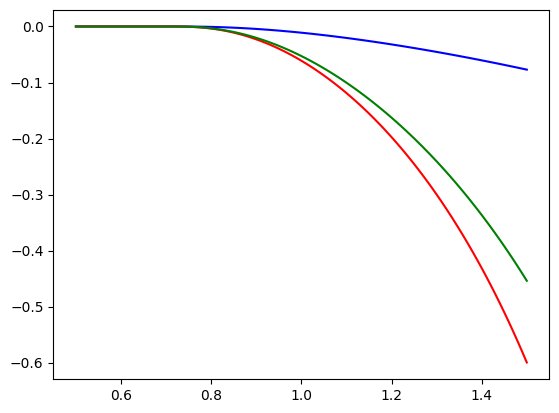

In [34]:
delta_I = []
delta_E = []

my_xcut = np.array([3])

def deltaI_I0 (q, beta, x_cut):
    return -q_exponential(-(3-q)*beta*x_cut**2/2, (1+q)/(3-q))

def deltaEpsilon_Epsilon0 (q, beta, x_cut):
    return (-q_exponential(-(5-3*q)*beta*x_cut**2/2, (3-q)/(5-3*q)) 
            - beta*(5-3*q)*x_cut**2/2*q_exponential(-(3-q)*beta*x_cut**2/2, (1+q)/(3-q)))

for my_q, my_beta in zip(q3, beta3):
    delta_I.append(deltaI_I0(my_q, my_beta, my_xcut))
    delta_E.append(deltaEpsilon_Epsilon0(my_q, my_beta, my_xcut))

delta_I = np.concat(delta_I) 
delta_I[np.isnan(np.array(delta_I))]=0
delta_I

delta_E = np.concat(delta_E) 
delta_E[np.isnan(np.array(delta_E))]=0
delta_E

plt.plot(q3, delta_I, 'b')
plt.plot(q3, delta_E, 'r')

plt.plot(q3, 2*delta_I+0.5*delta_E, 'g')


In [35]:
r=np.linspace(0,30,20000)
Lref = 2*np.trapezoid(q_gaussian(r, 1, 0.5)**2, r)

L=[]

for my_q, my_beta in zip([1],[0.5]):
    print(f'q={my_q}')
    q = my_q
    beta = my_beta
    r_cut = 30


    rho = ((3-q)*beta)*q_exponential(-(1+q)*beta*r**2/2, (3*q-1)/(1+q))/2/np.pi
    rho[np.where(r>r_cut)]=0
    from abel.direct import direct_transform
    from abel.tools.analytical import GaussianAnalytical
    aux=direct_transform(rho, dr=np.diff(r)[0], direction="forward", correction=True)

    L.append(2*np.trapezoid(aux**2, r)/Lref)
L = np.array(L)

q=1


In [36]:
aux[0]

np.float64(0.3989422801328184)

In [37]:
q_gaussian(0,1,0.5)

np.float64(0.39894228040143276)

# Plots

In [38]:
# at constant variance
q2=np.linspace(0.5, 1.5, 31)
beta2 = 1/(5-3*q2)


r=np.linspace(0,15,30000)
Lref = 2*np.trapezoid(q_gaussian(r, 1, 0.5)**2, r)


from scipy.optimize import root_scalar



#Find the root (must specify an interval [a, b] where f(a) and f(b) have opposite signs)
q3=np.linspace(0.5, 1.5, 31)
beta3 = []

for q in q3:
    # Define the function
    if q!=1:
        def f(x):
            return 2*np.trapezoid(q_gaussian(r, q, x)**2, r)/Lref - 1
        root = root_scalar(f, bracket=[.01, 5])  # Search between 0 and 5
        beta3.append(root['root'])
    else:
        beta3.append(0.5)
    #print( 2*np.trapezoid(q_gaussian(r, q, beta3[-1])**2, r)/Lref)


# at constant beta
q1=np.linspace(0.5, 1.5, 31)
beta1 = q1*0+0.5

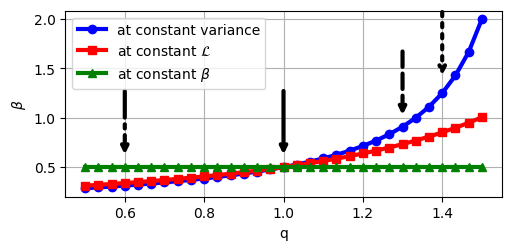

In [43]:
my_factor = 1.15
plt.figure(figsize=(6/my_factor, 3/my_factor)) 
plt.plot(q2, beta2,'-bo', lw=3, label = 'at constant variance')
plt.plot(q3, beta3,'-rs', lw=3, label = 'at constant $\\mathcal{L}$')
plt.plot(q1, beta1,'-g^' , lw=3, label = 'at constant $\\beta$')

plt.annotate(
    '',                         # No text
    xy=(0.6, 0.6),              # Arrow tip
    xytext=(0.6, 1.3),          # Arrow tail
    arrowprops=dict(
        arrowstyle='->',        # Simple arrow head
        linestyle='-.',     # Dotted line
        color='k',            # Optional: color
        linewidth=3             # Optional: line width
    )
)

plt.annotate(
    '',                         # No text
    xy=(1, 0.6),              # Arrow tip
    xytext=(1, 1.3),          # Arrow tail
    arrowprops=dict(
        arrowstyle='->',        # Simple arrow head
        linestyle='-',     # Dotted line
        color='k',            # Optional: color
        linewidth=3             # Optional: line width
    )
)

plt.annotate(
    '',                         # No text
    xy=(1.3, 1),              # Arrow tip
    xytext=(1.3, 1.7),          # Arrow tail
    arrowprops=dict(
        arrowstyle='->',        # Simple arrow head
        linestyle='--',     # Dotted line
        color='k',            # Optional: color
        linewidth=3             # Optional: line width
    )
)

plt.annotate(
    '',                         # No text
    xy=(1.4, 1.4),              # Arrow tip
    xytext=(1.4, 2.1),          # Arrow tail
    arrowprops=dict(
        arrowstyle='->',        # Simple arrow head
        linestyle=':',     # Dotted line
        color='k',            # Optional: color
        linewidth=3             # Optional: line width
    )
)


plt.grid()
plt.xlabel('q')
plt.ylabel('$\\beta$')
plt.legend()
plt.tight_layout()
plt.savefig('figures/beta_vs_q.pdf')

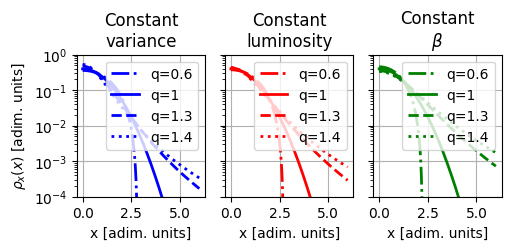

In [44]:
x=np.linspace(0,6,1000)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6/my_factor, 3/my_factor)) 

for my_q, my_style in zip([0.6, 1, 1.3, 1.4],['-.', '-', '--',':']):
    my_beta = np.interp(my_q, q2, beta2)
    axes[0].semilogy(x,q_gaussian(x, my_q,my_beta), 'b', lw=2, ls=my_style,  label=f'q={my_q}')#, $\\beta={my_beta:3.3}$')


for my_q, my_style in zip([0.6, 1,1.3, 1.4],['-.', '-', '--',':']):
    my_beta = np.interp(my_q, q3, beta3)
    
    axes[1].semilogy(x,q_gaussian(x, my_q,my_beta), 'r', lw=2, ls=my_style,  label=f'q={my_q}')#, $\\beta={my_beta:3.3}$')


for my_q, my_style in zip([0.6, 1,1.3, 1.4],['-.', '-', '--',':']):
    my_beta = np.interp(my_q, q1, beta1)
    
    axes[2].semilogy(x,q_gaussian(x, my_q,my_beta), 'g', lw=2, ls=my_style, label=f'q={my_q}')#, $\\beta={my_beta:3.3}$')

for i in range(3):
    axes[i].set_ylim(0.0001,1)
    axes[i].grid(True)
    axes[i].legend(loc='upper right')
    axes[i].set_xlabel('x [adim. units]')
    axes[i].set_ylabel('$\\rho_x(x)$ [adim. units]')

axes[0].set_title(
    '''Constant
variance''')

axes[1].set_title(
    '''Constant
luminosity''')

axes[2].set_title(
    '''Constant
$\\beta$''')


# Remove yticks and y-axis labels for axes[1] and axes[2]
for ax in axes[1:]:
    #ax.set_yticks([])           # Remove tick marks
    ax.set_yticklabels([])      # Remove tick labels
    ax.set_ylabel('')  # Remove axis label if set

plt.tight_layout()
plt.savefig('figures/profiles.pdf')

# Current variation

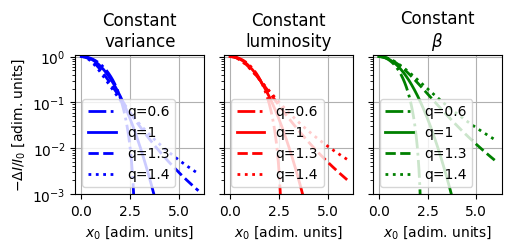

In [45]:
x=np.linspace(0,6,1000)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6/my_factor, 3/my_factor)) 
my_q_list = [0.6, 1, 1.3, 1.4]
my_stile_list = ['-.', '-', '--',':']

for my_q, my_style in zip(my_q_list,my_stile_list):
    my_beta = np.interp(my_q, q2, beta2)
    axes[0].semilogy(x,q_exponential(-(3-my_q)*my_beta/2*x**2, (1+my_q)/(3-my_q)), 'b', lw=2, ls=my_style,  label=f'q={my_q}')#, $\\beta={my_beta:3.3}$')


for my_q, my_style in zip(my_q_list, my_stile_list):
    my_beta = np.interp(my_q, q3, beta3)
    
    axes[1].semilogy(x,q_exponential(-(3-my_q)*my_beta/2*x**2, (1+my_q)/(3-my_q)), 'r', lw=2, ls=my_style,  label=f'q={my_q}')#, $\\beta={my_beta:3.3}$')


for my_q, my_style in zip(my_q_list, my_stile_list):
    my_beta = np.interp(my_q, q1, beta1)
    
    axes[2].semilogy(x,q_exponential(-(3-my_q)*my_beta/2*x**2, (1+my_q)/(3-my_q)), 'g', lw=2, ls=my_style, label=f'q={my_q}')#, $\\beta={my_beta:3.3}$')

for i in range(3):
    axes[i].set_ylim(0.001,1.1)
    axes[i].grid(True)
    axes[i].legend(loc='lower left')
    axes[i].set_xlabel('$x_0$ [adim. units]')
    axes[i].set_ylabel('$-\\Delta I/I_0$ [adim. units]')

axes[0].set_title(
    '''Constant
variance''')

axes[1].set_title(
    '''Constant
luminosity''')

axes[2].set_title(
    '''Constant
$\\beta$''')


# Remove yticks and y-axis labels for axes[1] and axes[2]
for ax in axes[1:]:
    #ax.set_yticks([])           # Remove tick marks
    ax.set_yticklabels([])      # Remove tick labels
    ax.set_ylabel('')  # Remove axis label if set

plt.tight_layout()
plt.savefig('figures/deltaI.pdf')

# Emittance 
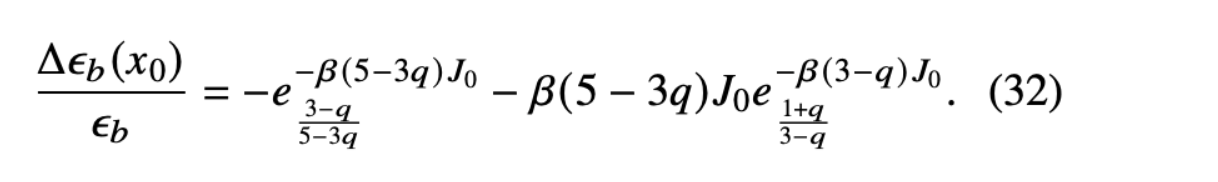

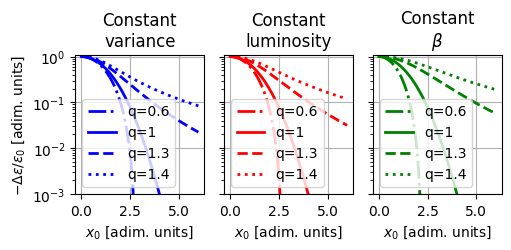

In [47]:
x=np.linspace(0,6,1000)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6/my_factor, 3/my_factor)) 
my_q_list = [0.6, 1, 1.3, 1.4]
my_stile_list = ['-.', '-', '--',':']

for my_q, my_style in zip(my_q_list, my_stile_list):
    my_beta = np.interp(my_q, q2, beta2)
    axes[0].semilogy(x,
                     q_exponential(-(5-3*my_q)*my_beta*x**2/2, (3-my_q)/(5-3*my_q))+
                     my_beta*(5-3*q)*x**2/2*q_exponential(-(3-my_q)*my_beta*x**2/2, (1+my_q)/(3-my_q)), 'b', lw=2, ls=my_style,  label=f'q={my_q}')#, $\\beta={my_beta:3.3}$')


for my_q, my_style in zip(my_q_list, my_stile_list):
    my_beta = np.interp(my_q, q3, beta3)
    
    axes[1].semilogy(x,
                     q_exponential(-(5-3*my_q)*my_beta*x**2/2, (3-my_q)/(5-3*my_q))+
                     my_beta*(5-3*q)*x**2/2*q_exponential(-(3-my_q)*my_beta*x**2/2, (1+my_q)/(3-my_q)), 'r', lw=2, ls=my_style,  label=f'q={my_q}')#, $\\beta={my_beta:3.3}$')


for my_q, my_style in zip(my_q_list, my_stile_list):
    my_beta = np.interp(my_q, q1, beta1)
    
    axes[2].semilogy(x,
                     q_exponential(-(5-3*my_q)*my_beta*x**2/2, (3-my_q)/(5-3*my_q))+
                     my_beta*(5-3*q)*x**2/2*q_exponential(-(3-my_q)*my_beta*x**2/2, (1+my_q)/(3-my_q)), 'g', lw=2, ls=my_style, label=f'q={my_q}')#, $\\beta={my_beta:3.3}$')

for i in range(3):
    axes[i].set_ylim(0.001,1.1)
    axes[i].grid(True)
    axes[i].legend(loc='lower left')
    axes[i].set_xlabel('$x_0$ [adim. units]')
    axes[i].set_ylabel('$-\\Delta \\epsilon/\\epsilon_0$ [adim. units]')

axes[0].set_title(
    '''Constant
variance''')

axes[1].set_title(
    '''Constant
luminosity''')

axes[2].set_title(
    '''Constant
$\\beta$''')


# Remove yticks and y-axis labels for axes[1] and axes[2]
for ax in axes[1:]:
    #ax.set_yticks([])           # Remove tick marks
    ax.set_yticklabels([])      # Remove tick labels
    ax.set_ylabel('')  # Remove axis label if set

plt.tight_layout()
plt.savefig('figures/deltaEmittance.pdf')

# Luminosity

In [48]:


def compute_it(r, r_cut, my_q, my_beta):
    q = my_q
    beta = my_beta
    
    rho = ((3-q)*beta)*q_exponential(-(1+q)*beta*r**2/2, (3*q-1)/(1+q))/2/np.pi
    J = r**2/2
    rhoJ = ((3-q)*beta)*q_exponential(-(1+q)*beta*J, (3*q-1)/(1+q))

    rho[np.isnan(rho)] = 0
    rhoJ[np.isnan(rhoJ)] = 0
    E0 = np.trapezoid(rhoJ*J, J)
    I0 = (np.trapezoid(rho*r*2*np.pi, r))
    
    rho[np.where(r>r_cut)] = 0
    rhoJ[np.where(J>r_cut**2/2)] = 0

    I = np.trapezoid(rho*r*2*np.pi, r)
    E = np.trapezoid(rhoJ*J, J)
    aux=direct_transform(rho, dr=np.diff(r)[0], direction="forward", correction=True)
    
    L = 2*np.trapezoid(aux**2, r)
    return {'L': L, 'I':I, 'E':E}



In [49]:
np.linspace(0,6,13)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ])

In [50]:
list_1 = []
for my_q, my_style in zip(my_q_list, my_stile_list):
    print(my_q)
    my_beta = np.interp(my_q, q1, beta1)
    ref = compute_it(np.linspace(0,30,25000), 30, my_q, my_beta)
    my_dict={}
    my_dict['q'] = my_q
    my_dict['beta'] = my_beta
    my_dict['r_cut'] = np.linspace(0,6,13)
    my_dict['DeltaL/L0'] = []
    for r_cut in my_dict['r_cut']:
        aux = compute_it(np.linspace(0,30,25000), r_cut, my_q, my_beta)
        my_dict['DeltaL/L0'].append((aux['L']-ref['L'])/ref['L'])
        print( my_dict['DeltaL/L0'])
    list_1.append(my_dict)

list_2 = []
for my_q, my_style in zip(my_q_list, my_stile_list):
    print(my_q)
    my_beta = np.interp(my_q, q2, beta2)
    ref = compute_it(np.linspace(0,30,25000), 30, my_q, my_beta)
    my_dict={}
    my_dict['q'] = my_q
    my_dict['beta'] = my_beta
    my_dict['r_cut'] = np.linspace(0,6,13)
    my_dict['DeltaL/L0'] = []
    for r_cut in my_dict['r_cut']:
        aux = compute_it(np.linspace(0,30,25000), r_cut, my_q, my_beta)
        my_dict['DeltaL/L0'].append((aux['L']-ref['L'])/ref['L'])
        print( my_dict['DeltaL/L0'])
    list_2.append(my_dict)

list_3 = []
for my_q, my_style in zip(my_q_list, my_stile_list):
    print(my_q)
    my_beta = np.interp(my_q, q3, beta3)
    ref = compute_it(np.linspace(0,30,25000), 30, my_q, my_beta)
    my_dict={}
    my_dict['q'] = my_q
    my_dict['beta'] = my_beta
    my_dict['r_cut'] = np.linspace(0,6,13)
    my_dict['DeltaL/L0'] = []
    for r_cut in my_dict['r_cut']:
        aux = compute_it(np.linspace(0,30,25000), r_cut, my_q, my_beta)
        my_dict['DeltaL/L0'].append((aux['L']-ref['L'])/ref['L'])
        print( my_dict['DeltaL/L0'])
    list_3.append(my_dict)

0.6
[np.float64(-1.0)]
[np.float64(-1.0), np.float64(-0.9354280838349356)]
[np.float64(-1.0), np.float64(-0.9354280838349356), np.float64(-0.6116493131319265)]
[np.float64(-1.0), np.float64(-0.9354280838349356), np.float64(-0.6116493131319265), np.float64(-0.19472620305767774)]
[np.float64(-1.0), np.float64(-0.9354280838349356), np.float64(-0.6116493131319265), np.float64(-0.19472620305767774), np.float64(-0.007998585879055565)]
[np.float64(-1.0), np.float64(-0.9354280838349356), np.float64(-0.6116493131319265), np.float64(-0.19472620305767774), np.float64(-0.007998585879055565), np.float64(0.0)]
[np.float64(-1.0), np.float64(-0.9354280838349356), np.float64(-0.6116493131319265), np.float64(-0.19472620305767774), np.float64(-0.007998585879055565), np.float64(0.0), np.float64(0.0)]
[np.float64(-1.0), np.float64(-0.9354280838349356), np.float64(-0.6116493131319265), np.float64(-0.19472620305767774), np.float64(-0.007998585879055565), np.float64(0.0), np.float64(0.0), np.float64(0.0)]
[np

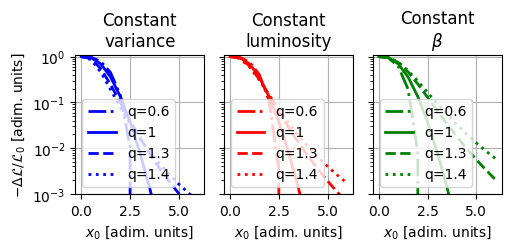

In [59]:
x=np.linspace(0,6,1000)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6/my_factor, 3/my_factor)) 
my_q_list = [0.6, 1, 1.3, 1.4]
my_stile_list = ['-.', '-', '--',':']

# for my_q, my_style in zip(my_q_list, my_stile_list):
#     my_beta = np.interp(my_q, q2, beta2)
#     axes[0].semilogy(x,
#                      q_exponential(-(5-3*my_q)*my_beta*x**2/2, (3-my_q)/(5-3*my_q))+
#                      my_beta*(5-3*q)*x**2/2*q_exponential(-(3-my_q)*my_beta*x**2/2, (1+my_q)/(3-my_q)), 'b', lw=2, ls=my_style,  label=f'q={my_q}')#, $\\beta={my_beta:3.3}$')


for ii, my_style in zip(range(4), my_stile_list):
    axes[0].semilogy(list_2[ii]['r_cut'],
                     np.abs(np.array(list_2[ii]['DeltaL/L0'])), 'b', lw=2, ls=my_style,  label=f'q={list_2[ii]['q']}')#, $\\beta={my_beta:3.3}$')


for ii, my_style in zip(range(4), my_stile_list):
    axes[1].semilogy(list_3[ii]['r_cut'],
                     np.abs(np.array(list_3[ii]['DeltaL/L0'])), 'r', lw=2, ls=my_style,  label=f'q={list_3[ii]['q']}')#, $\\beta={my_beta:3.3}$')


for ii, my_style in zip(range(4), my_stile_list):
    axes[2].semilogy(list_1[ii]['r_cut'],
                     np.abs(np.array(list_1[ii]['DeltaL/L0'])), 'g', lw=2, ls=my_style,  label=f'q={list_1[ii]['q']}')#, $\\beta={my_beta:3.3}$')


# for my_q, my_style in zip(my_q_list, my_stile_list):
#     my_beta = np.interp(my_q, q1, beta1)
    
#     axes[2].semilogy(x,
#                      q_exponential(-(5-3*my_q)*my_beta*x**2/2, (3-my_q)/(5-3*my_q))+
#                      my_beta*(5-3*q)*x**2/2*q_exponential(-(3-my_q)*my_beta*x**2/2, (1+my_q)/(3-my_q)), 'g', lw=2, ls=my_style, label=f'q={my_q}')#, $\\beta={my_beta:3.3}$')

for i in range(3):
    axes[i].set_ylim(0.001,1.1)
    axes[i].grid(True)
    axes[i].legend(loc='lower left')
    axes[i].set_xlabel('$x_0$ [adim. units]')
    axes[i].set_ylabel('$-\\Delta \\mathcal{L}/\\mathcal{L}_0$ [adim. units]')

axes[0].set_title(
    '''Constant
variance''')

axes[1].set_title(
    '''Constant
luminosity''')

axes[2].set_title(
    '''Constant
$\\beta$''')


# Remove yticks and y-axis labels for axes[1] and axes[2]
for ax in axes[1:]:
    #ax.set_yticks([])           # Remove tick marks
    ax.set_yticklabels([])      # Remove tick labels
    ax.set_ylabel('')  # Remove axis label if set

plt.tight_layout()
plt.savefig('figures/deltaL.pdf')